# Part 2 - Puffin Data analysis

![puffin_image](Puffin.jpg)

_Fratercula arctica, Fratercula cirrhata_ and _Fratercula corniculata_ are often nicknamed the clowns of the ocean due to their colourful beaks. They are an abundant genus with F.arctica having an estimated population size of - 5,700,000-6,000,000. (https://www.marinebio.org/species/atlantic-puffins/fratercula-arctica/) Machine learning models have emerged as a useful prediction tool within biological research to investigate morphological and ecological characteristics.

## Exploratory Data Analysis

To understand data structures and any relevant correlations that may have influence in later models. Any missing values can be identified and transformed.

The csv file is imported as a pandas dataframe.

In [1]:
import pandas as pd

data = pd.read_csv('puffins.csv')
data.head()

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,4.0,0.2,39.3,19.4,Arctica
1,3.1,0.2,38.6,18.3,Arctica
2,3.7,0.2,40.8,16.7,Arctica
3,4.5,0.2,41.5,17.9,Arctica
4,3.3,0.2,42.3,17.1,Arctica


### Cleaning

In [2]:
data.count()

body_mass_kg      341
wing_length_m     341
beak_length_mm    342
beak_depth_mm     342
species           344
dtype: int64

A count of the data columns shows we have a small data set with 5 columns.

In [3]:
data.isna().sum()

body_mass_kg      3
wing_length_m     3
beak_length_mm    2
beak_depth_mm     2
species           0
dtype: int64

10 Null values have been identified which will require cleaning before fitting any models.

In [4]:
data = data.interpolate(method='linear')
data.isna().sum()

body_mass_kg      0
wing_length_m     0
beak_length_mm    0
beak_depth_mm     0
species           0
dtype: int64

A linear interpolation method was used to fill in null values based on the existing values within the dataset. With the low level of nulls this should be suitable and not require more advanced SimpleImputer functions.

### Visualisation

A multi-variable pairplot matrix provides descriptive information on all the parameters.

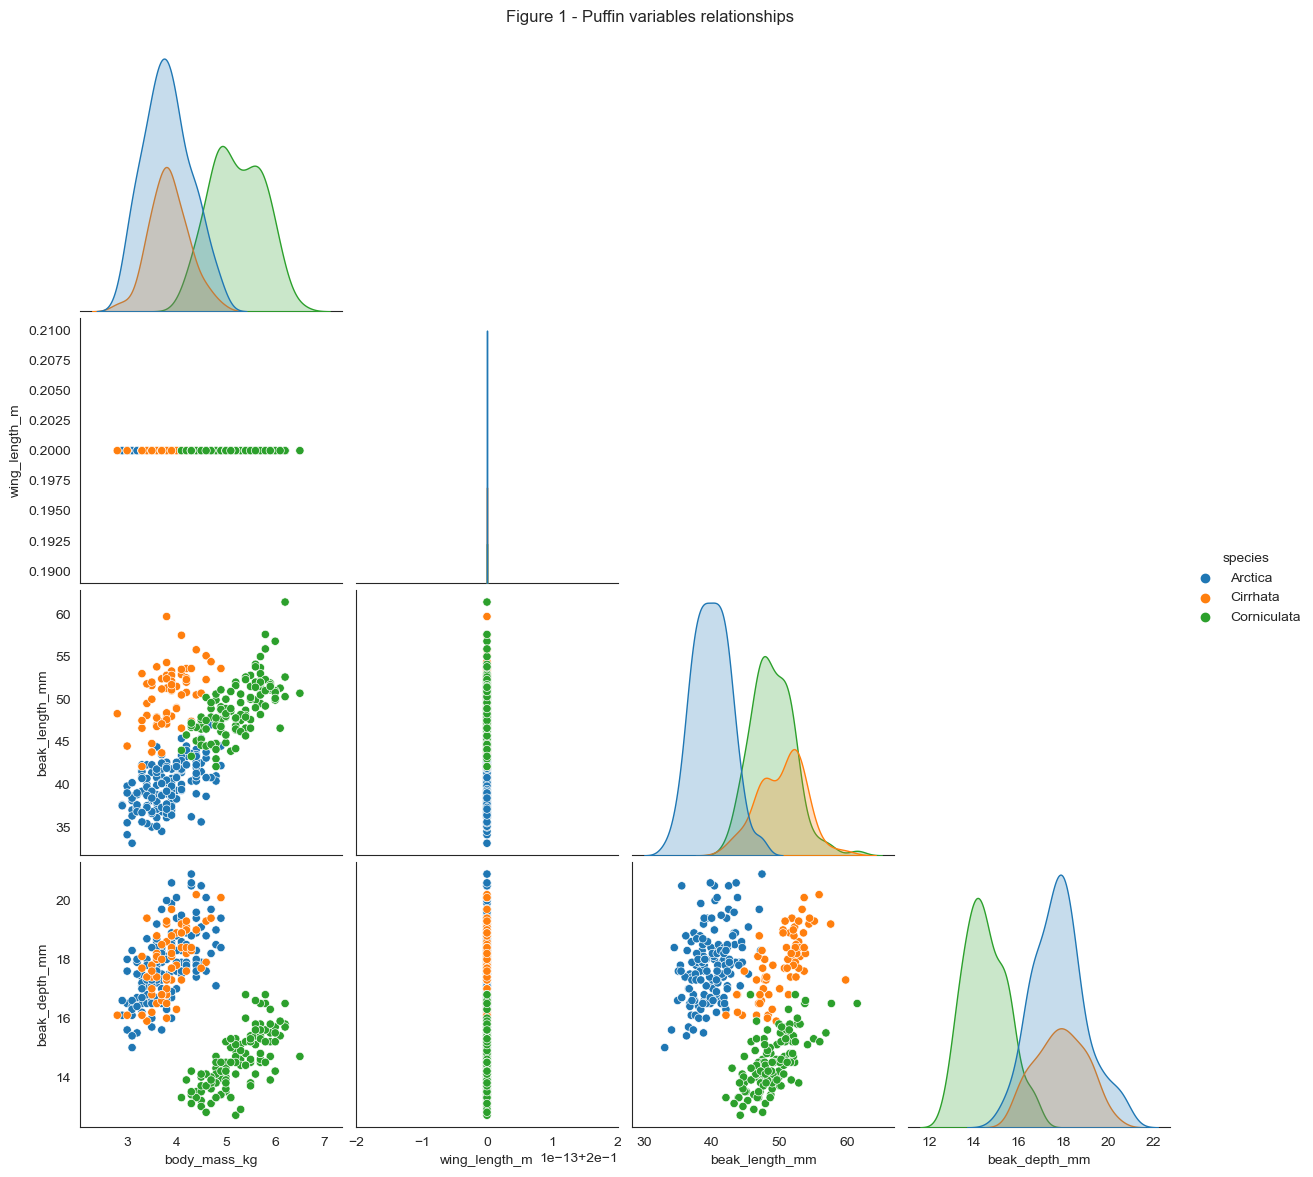

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
g = sns.pairplot(data, hue= "species", height=3,corner=True)
plt.suptitle("Figure 1 - Puffin variables relationships")
plt.subplots_adjust(top=0.95)



The output provides information on the parameters in this data.
1. wing_length_m has no variation in this dataset and will not be a useful feature for prediction.
1. There is a high proportion of clustering between species for the features body_mass_kg and beak_length_mm.
1. There is a high proportion of clustering  between species for the features beak_depth_mm and beak_length_mm
1. Arctica and Cirrhata have significant overlap in features beak_depth_mm and body_mass_kg.
1. A model with multiple features will be best to classify all species.
1. There are outliers in the data and observations that overlap classification boundaries.

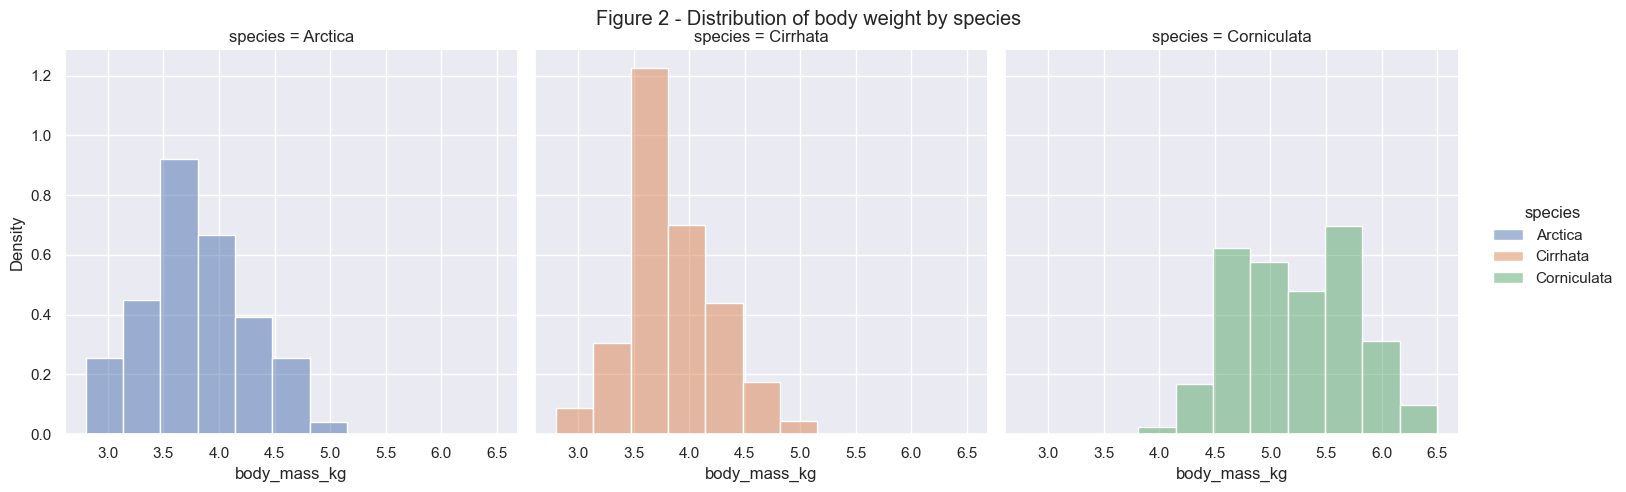

In [6]:
import seaborn as sns
sns.set_theme()

sns.displot(data = data, x ="body_mass_kg", hue = "species", col = "species", stat = "density", common_norm=False)
plt.subplots_adjust(top=0.90)
plt.suptitle("Figure 2 - Distribution of body weight by species")
plt.show()

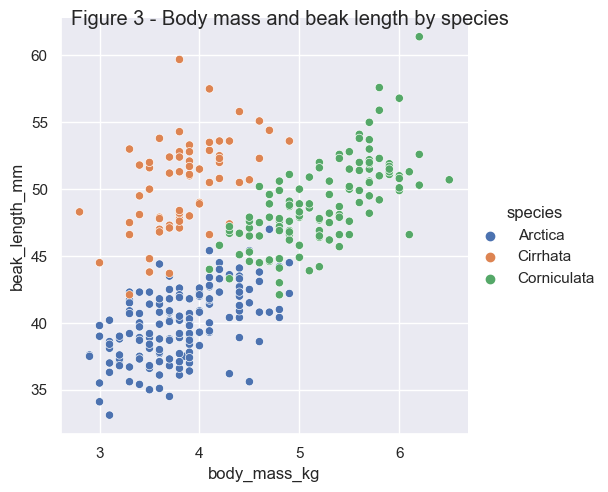

In [7]:
sns.relplot(data = data, x ="body_mass_kg", y = "beak_length_mm" , hue = "species")
plt.suptitle("Figure 3 - Body mass and beak length by species")
sns.set_style("whitegrid")
plt.show()


The scatter plot does display some grouping of data points by each species which justifies testing out the K-nearest neighbours classification model.

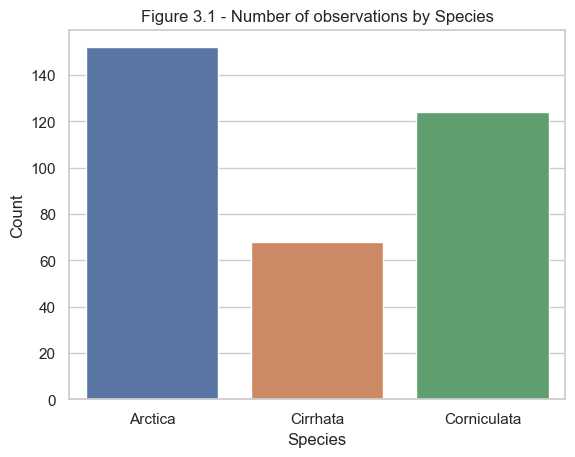

In [8]:
sns.countplot(x="species", data=data)
# Add axis labels and title
plt.xlabel("Species")
plt.ylabel("Count")
plt.title("Figure 3.1 - Number of observations by Species")
plt.show()

There is not an equal amount of groups in this sample it is biased towards Arctica and Corniculata.

### Correlation Analysis

Create a dataframe of pearson's correlation co-efficients. 

In [9]:
import numpy as np
corr = data.corr(method='pearson')
np.fill_diagonal(corr.values, np.nan)
corr

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm
body_mass_kg,NaN,NaN,0.597139,-0.473747
wing_length_m,NaN,NaN,NaN,NaN
beak_length_mm,0.597139,NaN,NaN,-0.240245
beak_depth_mm,-0.473747,NaN,-0.240245,NaN


Identify the variables with highest positive correlation and its value.

In [10]:
corr.max().idxmax(), corr[corr.max().idxmax()].idxmax()


('body_mass_kg', 'beak_length_mm')

In [11]:
corr.max().max()

0.5971393077881822

Identify the variables with lowest correlation and its value.

In [12]:
corr.min().idxmin(), corr[corr.min().idxmin()].idxmin()

('body_mass_kg', 'beak_depth_mm')

In [13]:
corr.min().min()

-0.47374737293812386

Text(0.5, 0.98, 'Figure 4 - Correlation heatmap')

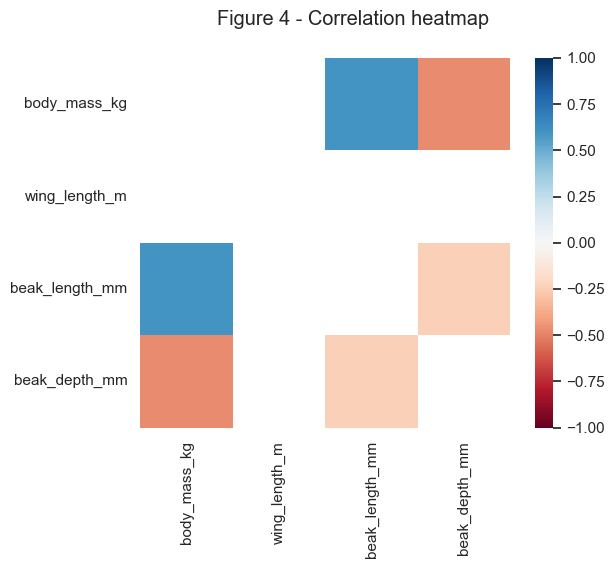

In [14]:
%matplotlib inline

import seaborn as sns

sns.heatmap(corr, vmin=-1.0, vmax=1.0, square=True, cmap="RdBu")
plt.suptitle("Figure 4 - Correlation heatmap")

There is a moderate positive correlation between beak_length_mm and body mass_mm.
There is a moderate negative correlation between beak_depth_mm and body_mass_mm influenced by species group (figure 1).

The below function returns the correlation co-efficients and p-values for numerical columns in a dataset which are statistically signficant.

In [15]:
import pandas as pd
from scipy import stats

def calculate_correlations(df, columns):
    """
    Tabulate pearson's correlation co-efficients and p-values for numerical columns.
    
    Args:
        df (pandas.core.frame.DataFrame): The source database to use. Must be loaded already.
        columns (list): A list of numerical columns present in df for analysis.
        
    Returns: 
        correlations, p_values (pandas.core.frame.DataFrame)
    
    Example:
       correlations, p_vals = calculate_correlations(data, ['column1','column2'])   
    
    """
    # Raise error for non-numerical values
    if not all(pd.api.types.is_numeric_dtype(df[col]) for col in columns):
        raise ValueError(f"The column {columns} is not numerical, please input another column parameter for correlation analysis.")
    else:
        #dict to store results
        correlations = {}
        p_values = {}
        #loop around column pair
        for col1 in columns:
            correlations[col1] = {}
            p_values[col1] = {}
            for col2 in columns:
                #check for unique values to avoid correlation errors.
                if df[col1].nunique() > 1 and df[col2].nunique() > 1:
                    #calculate the pearsons correlation
                    corr, p = stats.pearsonr(df[col1], df[col2])
                else:
                    #set to Nan if only 1 value
                    corr, p = np.nan, np.nan
                #store results in the directory
                correlations[col1][col2] = corr
                p_values[col1][col2] = p
    return pd.DataFrame(correlations), pd.DataFrame(p_values)

In [16]:
correlations, p_vals = calculate_correlations(data, ['beak_length_mm', 'body_mass_kg', 'beak_depth_mm'])

In [17]:
p_vals

,beak_length_mm,body_mass_kg,beak_depth_mm
beak_length_mm,0.000000e+00,1.286442e-34,6.611721e-06
body_mass_kg,1.286442e-34,0.000000e+00,1.200510e-20
beak_depth_mm,6.611721e-06,1.200510e-20,0.000000e+00


# Machine Learning

## Data transformation
Transforming the categorical variable to a numerical key of 0, 1, 2 allows for better analysis of sci-kit learn tools and the plot.py function. <br>
Having a label mapping is useful to refer back to the full species description.

In [18]:
from sklearn.preprocessing import LabelEncoder

# Define your categorical labels
labels = ['Arctica', 'Cirrhata', 'Corniculata']

# Create a LabelEncoder object and fit it to your labels
encoder = LabelEncoder()
encoder.fit(labels)

# Transform your categorical labels to numeric labels
numeric_labels = encoder.transform(labels)

# Print the resulting numeric labels
numeric_labels

#create a mapping for reference.
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
label_mapping

{'Arctica': 0, 'Cirrhata': 1, 'Corniculata': 2}

## Data Preperation
Data manipulation is required to create the correct input parameters with a 2D shape for the features in X and a 1D shape for the labels in y.

In [19]:
data.head()

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm,species
0,4.0,0.2,39.3,19.4,Arctica
1,3.1,0.2,38.6,18.3,Arctica
2,3.7,0.2,40.8,16.7,Arctica
3,4.5,0.2,41.5,17.9,Arctica
4,3.3,0.2,42.3,17.1,Arctica


Create a subset feature and full feature X.

In [20]:
X_s = data[["body_mass_kg", "beak_length_mm"]] #subset of two features minus labels
X = data.iloc[:, :-1] # all features minus labels
X_s.head()

,body_mass_kg,beak_length_mm
0,4.0,39.3
1,3.1,38.6
2,3.7,40.8
3,4.5,41.5
4,3.3,42.3


In [21]:
y = data["species"]
y.head()

0    Arctica
1    Arctica
2    Arctica
3    Arctica
4    Arctica
Name: species, dtype: object

y is then encoded with the earlier sci-kit learn encoder.

In [22]:
# Transform your categorical labels to numeric labels
y_encoded = encoder.transform(y)
y_encoded[:5]

array([0, 0, 0, 0, 0])

The initial machine learning analysis will use the variables with the highest positive correlation ("body_mass_kg", "beak_length_mm").

Next, the data is split into test and training subsets and the model is fit.

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Transform the categorical labels to numeric labels
y_encoded = encoder.transform(y)

#sub set the data 
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X_s, y_encoded, random_state=30)

#select model and fit the using the train subset.
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X_s, train_y_s)

KNeighborsClassifier()

In [24]:
model.score(test_X_s, test_y_s)

0.9302325581395349

Text(0.5, 0.98, 'Figure 5 - Visualising initial classfication boundaries')

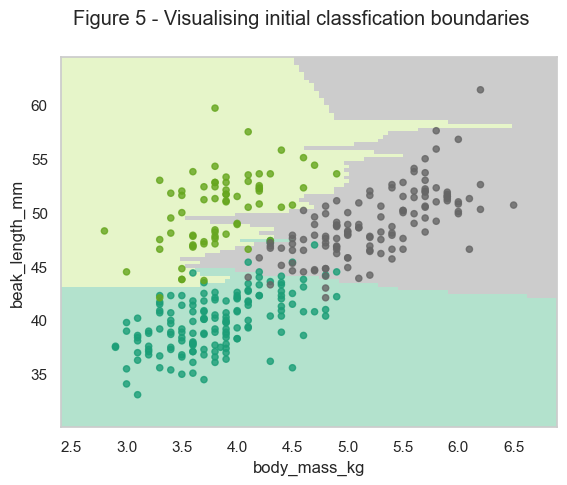

In [25]:
from plot import plot_knn
plot_knn(model, X_s, y_encoded)
plt.suptitle("Figure 5 - Visualising initial classfication boundaries")

The visual analysis from the plot_knn function displays 3 classification boundaries but there are some overlapping regions that would benefit from improvement, alongside the low score of 0.93 for this small dataset.

## Feature Selection Analysis

An initial model has been generated but feature analysis is important to determine how the different variables impact on performance. 

In [26]:
X.head()

,body_mass_kg,wing_length_m,beak_length_mm,beak_depth_mm
0,4.0,0.2,39.3,19.4
1,3.1,0.2,38.6,18.3
2,3.7,0.2,40.8,16.7
3,4.5,0.2,41.5,17.9
4,3.3,0.2,42.3,17.1


In [27]:
# Create lists of all the different features available.
features_1 = ["body_mass_kg"]
features_2 = ["body_mass_kg", "beak_length_mm"]
features_3 = ["body_mass_kg", "beak_length_mm", "beak_depth_mm"]
features_4 = ["body_mass_kg", "beak_length_mm", "beak_depth_mm", "wing_length_m"]


# Split the data into test and train subsets
X = data[features_4]
y = data["species"]
train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, random_state=30)

# Transform the categorical labels to numeric labels
y_encoded = encoder.transform(y)

# Train and evaluate the model on the feature subsets
results = []
for features in [features_1, features_2, features_3, features_4]:
    X = data[features]
    train_X, test_X, train_y, test_y = train_test_split(X, y_encoded, random_state=30)
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(train_X, train_y)
    score = model.score(test_X, test_y)
    results.append({"Features": ", ".join(features), "Score": score})

# Store the results in a dataframe.
results_df = pd.DataFrame(results)

In [28]:
results_df

,Features,Score
0,body_mass_kg,0.627907
1,"body_mass_kg, beak_length_mm",0.930233
2,"body_mass_kg, beak_length_mm, beak_depth_mm",0.988372
3,"body_mass_kg, beak_length_mm, beak_depth_mm, w...",0.988372


The results indicate that body_mass_kg, beak_length_mm, beak_depth_mm look to perform the best, for now lets keep the features at two (Xs) for hyper-parameter analysis.

## Hyperparameter analysis
Lets determine if the high performing model can be improved by adjusting the hyper-parameters.

In [29]:
# Species Classification - subset - required to refresh after previous loop.

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

# Transform the categorical labels to numeric labels
y_encoded = encoder.transform(y)

# Split the data into test and train models
train_X_s, test_X_s, train_y_s, test_y_s = train_test_split(X_s, y_encoded, random_state=30)
# fit the model
model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_X_s, train_y_s)

# view model score result
model.score(test_X_s, test_y_s)

0.9302325581395349

The GridSearchCV function allows the hyperparamter n_neighbours to be compared.

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

parameters = {
    "n_neighbors" : range(1, 60),
}
model = GridSearchCV(KNeighborsClassifier(), parameters)
model.fit(train_X_s, train_y_s)


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 60)})

Text(0.5, 0.98, 'Figure 6 - n neighbours mean test scores')

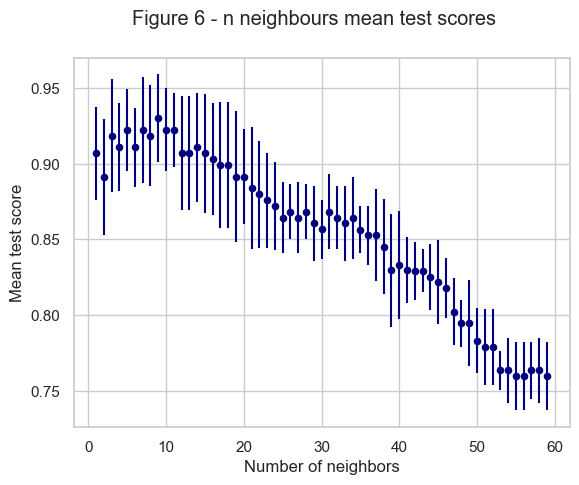

In [31]:
import matplotlib.pyplot as plt
cv_results = pd.DataFrame(model.cv_results_)
cv_results.plot.scatter("param_n_neighbors", "mean_test_score", yerr="std_test_score", c="navy")
plt.ylabel("Mean test score")
plt.xlabel("Number of neighbors")
plt.suptitle("Figure 6 - n neighbours mean test scores")

In [32]:
cv_results = cv_results.sort_values(["rank_test_score", "mean_test_score"])
cv_results.head()[["param_n_neighbors", "mean_test_score", "std_test_score", "rank_test_score"]]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
8,9,0.930241,0.028779,1
4,5,0.922549,0.027044,2
9,10,0.922474,0.027314,3
10,11,0.922474,0.024456,3
6,7,0.922398,0.034790,5


## Feature scaling 

In [33]:
X_s.head()

,body_mass_kg,beak_length_mm
0,4.0,39.3
1,3.1,38.6
2,3.7,40.8
3,4.5,41.5
4,3.3,42.3


In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_s)

StandardScaler()

In [35]:
X_scaled_raw = scaler.transform(X_s)
X_scaled = pd.DataFrame(X_scaled_raw, columns=X_s.columns)
X_scaled.head()

,body_mass_kg,beak_length_mm
0,-0.398603,-1.055477
1,-1.490222,-1.180062
2,-0.762476,-0.788510
3,0.207852,-0.663926
4,-1.247640,-0.521543


In [36]:
from sklearn.pipeline import make_pipeline

scaled_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier()
)
scaled_knn

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [37]:
scaled_knn.fit(train_X_s, train_y_s)
scaled_knn.score(test_X_s, test_y_s)

0.9302325581395349

## Principal component analysis

PCA analysis can be carried out on all the features in the dataset to determine what is the best number of components.

In [38]:
# Species Classification - all features

# Split the data into test and train models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=30) # all features


In [39]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

scaled_pca_knn = make_pipeline(
    StandardScaler(),
    PCA(n_components=2),  # PCA with 2 components
    KNeighborsClassifier()
)
scaled_pca_knn

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [40]:
scaled_pca_knn.fit(train_X, train_y)
scaled_pca_knn.score(test_X, test_y)

0.8953488372093024

Using this method the model score has decreased but it is not possible to specify variable name.

In [41]:
scaled_pca_knn["pca"].explained_variance_ratio_

array([0.62903869, 0.26296044])

In [42]:
sum(scaled_pca_knn["pca"].explained_variance_ratio_)

0.8919991298614363

Now lets use gridSearchCV to find the best number of components for the model.

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

scaled_pca_knn_cv = GridSearchCV(
    make_pipeline(
      StandardScaler(),
        PCA(),
        KNeighborsClassifier()
    ),
    {
        "pca__n_components" : range(1, 4),
    }
)
scaled_pca_knn_cv

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'pca__n_components': range(1, 4)})

In [44]:
scaled_pca_knn_cv.fit(train_X, train_y)
scaled_pca_knn_cv.score(test_X, test_y)

1.0

In [45]:
print("Best Hyperparameters: ", scaled_pca_knn_cv.best_params_)
print("Best Mean Test Score: ", scaled_pca_knn_cv.best_score_)

Best Hyperparameters:  {'pca__n_components': 3}
Best Mean Test Score:  0.9845399698340875


The principle component analysis has reinforced that 3 data items provide the best mean model score.
Along with the earlier feature analysis it is justified to remove wing_length_m from the model.
The scaling does give a perfect score for this result which may be due to the removal of outliers.

## Final model and Predictions
The justification for not using the scaled pca model with 100% score is that the transformations may be overfitting. This is a relatively small dataset and a 100 percent prediction rate is unlikely.

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

X3_s = data[["body_mass_kg", "beak_length_mm", "beak_depth_mm"]] #subset of 3 features

# Transform your categorical labels to numeric labels
y_encoded = encoder.transform(y)

train_X, test_X, train_y, test_y = train_test_split(X3_s, y_encoded, random_state=30)  # re-split using all columns

model = KNeighborsClassifier(n_neighbors=9)
model.fit(train_X, train_y)

KNeighborsClassifier(n_neighbors=9)

In [47]:
model.score(test_X, test_y)

0.9883720930232558

Create some values to predict.

In [48]:
new_X = pd.DataFrame({
    "body_mass_kg": [4.7, 6.7, 10],
    "beak_length_mm": [40.8, 60, 53],
    "beak_depth_mm": [18.8, 20.5, 11]
})

new_y = model.predict(new_X)


The encoder can be used to read the predicted descriptions.

In [49]:
encoder.inverse_transform(new_y)

array(['Arctica', 'Cirrhata', 'Corniculata'], dtype='<U11')

In [50]:
label_mapping

{'Arctica': 0, 'Cirrhata': 1, 'Corniculata': 2}

## Model Cross-validation
This helps to ensure the test and train subsets are representative.

In [51]:
from sklearn.model_selection import cross_val_score
cross_val_score(model, X3_s, y_encoded, cv=5)

array([1.        , 1.        , 0.97101449, 0.95652174, 0.95588235])

In [52]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X3_s, y_encoded, cv=LeaveOneOut())
scores.mean()

0.9738372093023255

## Confusion matrix analysis
This matrix provides a visual representation of false postives by species.

Text(0.5, 0.98, 'Figure 7 - Actual against model predictions')

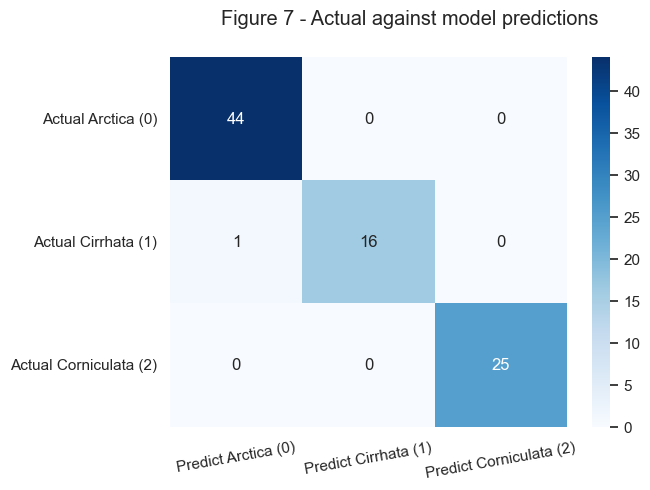

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the test labels
y_pred = model.predict(test_X)

# Create a confusion matrix
cm = confusion_matrix(test_y, y_pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d"
            , xticklabels=['Predict Arctica (0)', 'Predict Cirrhata (1)', 'Predict Corniculata (2)']
            , yticklabels=['Actual Arctica (0)', 'Actual Cirrhata (1)', 'Actual Corniculata (2)'])
plt.xticks(rotation=10)
plt.suptitle("Figure 7 - Actual against model predictions")

This figure identifies false positive and negative results against true positives and negatives observed in the dataset. The model prediction has one false positive predicting species 0 (Arctica) when it was actually species 1 (Cirrhata). Anything outside of the diagonal is an type 1 or 2 error.

## Classification Report

In [54]:
from sklearn.metrics import classification_report

#use key from earlier mapping dict
labels = label_mapping.keys()

report =  classification_report(test_y, y_pred, target_names = labels, output_dict=True)

report_data = pd.DataFrame(report).transpose()
report_data


,precision,recall,f1-score,support
Arctica,0.977778,1.000000,0.988764,44.000000
Cirrhata,1.000000,0.941176,0.969697,17.000000
Corniculata,1.000000,1.000000,1.000000,25.000000
accuracy,0.988372,0.988372,0.988372,0.988372
macro avg,0.992593,0.980392,0.986154,86.000000
weighted avg,0.988630,0.988372,0.988261,86.000000


## Area under the curve AUC

In [55]:
from sklearn.metrics import roc_auc_score
# Calculate the AUC for each class
auc_scores = roc_auc_score(test_y, model.predict_proba(test_X), multi_class='ovo')
auc_scores


0.999554367201426

Draft AUC analysis shows high performance of the model, the next steps would be to attempt plotting this.

# Discussion

This data analysis pipeline has trained a high performing multi supervised classification model using the Nearest Neighbours functionality from sci-kit learn (Goldberger et al., 2004). The final model performance achieved was 0.99 with the ability to reliably predict discrete species labels from observational features found in the puffins.csv dataset.
The effectiveness of the model has been measured by splitting the data into test and train subsets to assess model score. Additionally, cross validation analysis has reconfirmed performance against the original subsets. Finally,  a confusion matrix has provided insight into the false positives (n =1) by comparing actual labels to the predicted (Figure 7).  While attempting a data transformation using the default Standard scaler function parameters a 1.0 performance was achieved. However, this model was discarded due to the assumed overfitting and inaccuracies caused by transformation. <br>
While high performance has been achieved on this dataset there is likely to be significant overfitting due to the limited features in the dataset.  For example, the lack of variation in wing length (m) is a limitation, possibly explained by an unwarranted rounding process. The sample size is also relatively small (n = 344) and it is unlikely to be fully representative of the global or regional puffin population. Confounding variables such as age and biological sex are missing and likely influencing the results.  <br>
To conclude, further machine learning analysis would be required to add more feature complexity and reduce bias within the model. A better measure of effectiveness would be to apply this model to an external dataset not used in the development of this model.

# References

1. Goldberger, J., Hinton, G. E., Roweis, S. & Salakhutdinov, R. R. 2004. Neighbourhood components analysis. Advances in neural information processing systems, 17.

2. Sci-kit learn online resources, https://scikit-learn.org/stable/modules/neighbors.html

3. The data used in this analysis, https://www.ole.bris.ac.uk/bbcswebdav/pid-7121622-dt-content-rid-38555550_2/xid-38555550_2

4. Additional Reading on assesing model quality, https://jakevdp.github.io/PythonDataScienceHandbook/index.html

1. Nearest neighbours model inspired by, https://milliams.com/courses/applied_data_analysis/Nearest%20Neighbours.html

1. Feature scaling and Princple Componet Analysis - https://milliams.com/courses/applied_data_analysis/appendix_scaling.html